# SPAM detection with NLP processing

The project is to build a model able to dectect wether an SMS is an spam or not. To do so we will first treat the SMS with **NLP mehtod**. 

Then we will try to apply an **classification model** on the treated SMS



### package import

In [60]:
import pandas as pd
import spacy
import re
from unidecode import unidecode
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords

#change the working directory if necessary
df_eng=pd.read_csv(r'C:\Users\UTILISATEUR\Desktop\Spam\Spam_dataset.csv',sep=';')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UTILISATEUR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **EDA** (Exploratory Data Analysis)

In [61]:
df_eng['Nature'].value_counts()

ham     4825
spam     747
Name: Nature, dtype: int64

Ham is over represented we risk that the model will overfit on the ham. We will ve carefull before trying to build a predictive model

### Cleaning the sms

In [62]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [63]:
#Count upper case
df_eng['count_upper']=df_eng.SMS.apply(lambda text: len(re.findall(r'[A-Z]',text))/len(text))
print(df_eng.iloc[5370,1])
#Remove upper case
df_eng.SMS=df_eng.SMS.str.lower()
print(df_eng.iloc[5370,1])
#remove accent
df_eng.SMS=df_eng.SMS.apply(lambda text: unidecode(text))


# Replace email address with 'emailaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress',x))
print(df_eng.iloc[5370,1])
# Replace urls with 'webaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^http?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+(\.[a-zA-Z]+){1,4}', 'webaddress',x))


print(df_eng.iloc[5370,1])
# Replace money symbol with 'money-symbol'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^(( )*\£{0,1}( )*)\d*(.\d{1,2})?$', 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'PS\d+(,\d+)?' , 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?p' , 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?ppm' , 'moneynumb',x))

#replace hours
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?(am|pm)' , 'hour',x))


print(df_eng.iloc[5370,1])
#replace numbers
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d{10,15}','phonenumber',x))
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d+','number',x))
print(df_eng.iloc[5370,1])


#retirer la ponctuation
df_eng.SMS=df_eng.SMS.apply(lambda text: text.translate(str.maketrans(string.punctuation ,' '*len(string.punctuation ))
                                                             ).replace(' '*4,' ').replace(' '*3,' ').replace(' '*2,' ').strip())

dating:i have had two of these. Only started after i sent a text to talk sport radio last week. Any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?


### Lemmatize the sms

In [64]:
#Function to lemmatize the text and take out some ponctuation and the names of peoples
def lemmatize(text):
    lemmatized_array=[]
    doc=nlp(u'{}'.format(text))
    for token in doc:
        if token.lemma_ not in ("'",",","[","]") and (not token.ent_type_ == "PER"):
            lemmatized_array.append(token.lemma_)
    return lemmatized_array

In [65]:
df_nlp_eng=df_eng.copy()

In [66]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda x: lemmatize(x))

### Stopwords treatment

In [67]:
stopWords = set(stopwords.words('english'))
stopWords.update(('nt','pl','c'))
def remove_sw(text):
    return[w for w in text if w not in stopWords]

In [68]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda text: remove_sw(text))

### Word cloud

In [69]:
df_cloud=df_nlp_eng.copy()

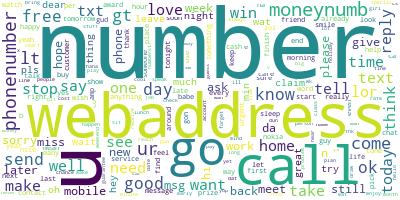

In [70]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
df_cloud.SMS=df_cloud.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

##### Word cloud of spams and non spam

In [71]:
df_cloud_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_cloud_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']

c:\Users\UTILISATEUR\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


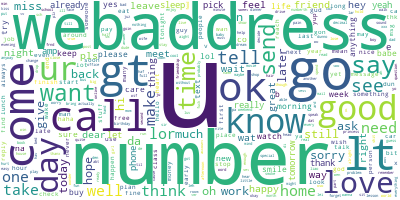

In [72]:
df_cloud_ham.SMS=df_cloud_ham.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_ham.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

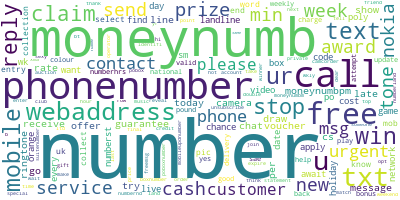

In [73]:
df_cloud_spam.SMS=df_cloud_spam.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_spam.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Predictive model

#### Downsampling the data

In [74]:
# check percentage of data - states how much data needs to be balanced
print(str(round(747/4825,2))+'%')

0.15%


In [75]:
#clear empty fields
df_nlp_eng=df_nlp_eng[df_nlp_eng['SMS'].map(len)>0]

#we separe the two type of data
df_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']


df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

# get the balanced dataset
df_model= pd.concat([df_spam , df_ham_downsampled])

In [76]:
#Change the categorical variable to numerical one
df_model['is_spam']=df_model['Nature'].apply(lambda x: 1 if x=='spam'else 0)

#### Compute the TF-IDF score

In [77]:
#Join the list of word to apply the tf_idf
df_model.SMS=df_model.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model.SMS)

In [78]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model.index,inplace=True)

In [79]:
#Concatenate the score of tf-idf and the initial dataframe
df_model=pd.concat([df_model , tfidf_df],axis=1)

#### Random Forest Classifier Reg

In [80]:
#Separate the training set in differents one
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

<ipython-input-80-936c8b35ea25>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [81]:
df_=(df_model.merge(X_test, left_index=True,right_index=True ,how='inner')).merge(pd.DataFrame({'pred':list(y_pred),'index': X_test.index}).set_index('index'),left_index=True,right_on='index')


In [82]:
for i in df_[df_['is_spam']!=df_['pred']].index:
    print(df_.loc[i,'SMS'])

sm ac sptv new jersey devil detroit red wing play ice hockey correct incorrect end reply end sptv
unique enough find numberth august webaddress
forward phonenumber please call phonenumber immediately urgent message wait
important customer service announcement premier
reminder download content already pay goto http doit mymoby tv collect content
phonenumber win moneynumb price claim call phonenumber
please call phonenumber immediately urgent message wait
would like see xxx pic hot nearly ban uk
sexy single wait text age follow gender wither f webaddress numberf gay man text age follow g webaddress numberg
hi ya babe x u numbergoten bout I scammer get webaddress regular vodafone respond get prem rate msg subscription nos use also beware
webaddress game thedailydraw dear helen dozen free game great prizeswith
next amazing xxx picsfreenumber video send enjoy one vid enough numberday text back keyword picsfreenumber get next video
hello darle today I would love chat tell I look like sexy
fr

In [83]:
df_[df_['is_spam']!=df_['pred']]

,Nature,SMS,count_upper_x,is_spam,ab_x,abdoman_x,aberdeen_x,abiola_x,able_x,abroad_x,...,yr_y,yrs_y,yummy_y,yuo_y,yup_y,ze_y,zebra_y,zoe_y,zouk_y,pred
index,,,,,,,,,,,,,,,,,,,,,
54,spam,sm ac sptv new jersey devil detroit red wing p...,0.200000,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
191,spam,unique enough find numberth august webaddress,0.041667,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
690,spam,forward phonenumber please call phonenumber im...,0.054054,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
752,spam,important customer service announcement premier,0.123077,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
881,spam,reminder download content already pay goto htt...,0.023622,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1118,spam,phonenumber win moneynumb price claim call pho...,0.028986,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1252,spam,please call phonenumber immediately urgent mes...,0.061728,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1875,spam,would like see xxx pic hot nearly ban uk,0.047619,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2071,spam,sexy single wait text age follow gender wither...,0.154362,1,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Visualisation error

Text(105.0, 0.5, 'Actual')

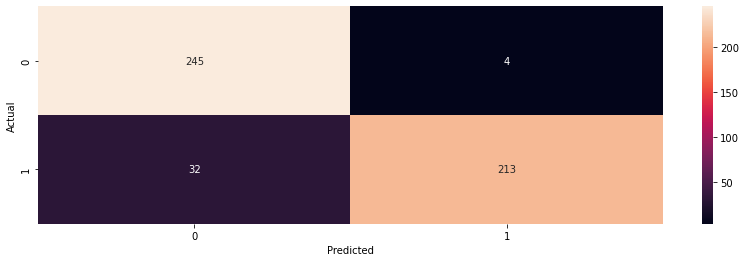

In [84]:
cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Model on the whole dataset

In [85]:
df_test=df_nlp_eng.copy()

In [86]:
#Join the list of word to apply the tf_idf
df_test.SMS=df_test.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_test.SMS)

In [87]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_test.index,inplace=True)

In [88]:
#Concatenate the score of tf-idf and the initial dataframe
df_test=pd.concat([df_test , tfidf_df],axis=1)

Text(105.0, 0.5, 'Actual')

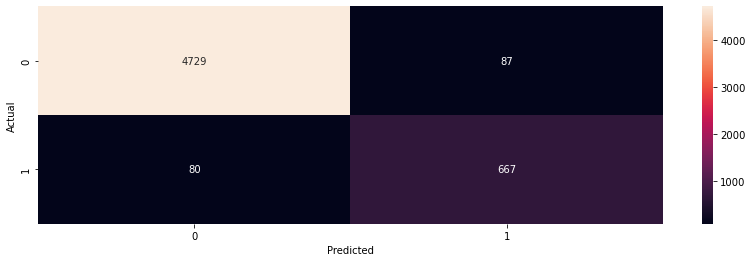

In [89]:
df_test['is_spam']=df_test['Nature'].apply(lambda x: 1 if x=='spam'else 0)


X=df_test[df_test.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[X_model.columns]
y=df_test[['is_spam']]
y_pred=clf.predict(X)
cm = confusion_matrix(y,y_pred)

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## N-GRAMS

For the N-gram we will use the sentences that are pre-proceced(lemmatize and cleaned of stopword)s

#### Visualization of bi-grams

In [90]:
df_gram=df_nlp_eng.copy()
df_gram['is_spam']=df_gram['Nature'].apply(lambda x: 1 if x=='spam'else 0)

In [91]:
#Fond all the bigram in the texts
def get_grams(data):

    bigrams_final=[]
    bigrams_values=0
    bigrams_labels=0
    for bigram in data.SMS:
        for i in range(0,len(bigram)-1):
            bigram_list_basic=bigram[i]+" "+bigram[i+1]
            bigrams_final.append(bigram_list_basic)

                
    bigrams_final = pd.DataFrame(bigrams_final) 
    bigrams_final.columns=["bigrams"]
    bigrams_values=bigrams_final.groupby("bigrams")["bigrams"].count()
    bigrams_labels=bigrams_final.groupby("bigrams").groups.keys()
    bigrams_final_result = pd.DataFrame(
    {
        "bigram":[*bigrams_labels],
        "count":bigrams_values
    }
    )
    return bigrams_final_result

In [92]:
df_bigram1=get_grams(df_gram[df_gram['is_spam']==1])
df_bigram2=get_grams(df_gram[df_gram['is_spam']==0])

In [93]:
def plot_grams(df_bigram,gram_n,height=4, width=14):
    bigrams_final = df_bigram
    bigrams_final = bigrams_final.sort_values("count",ascending=False).iloc[:15]
    plt.barh(bigrams_final["bigram"],bigrams_final["count"], align="center", alpha=0.7)
    plt.xlabel('Count')
    plt.title('Most common bigrams')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.show()
    plt.rcParams["figure.figsize"] = fig_size

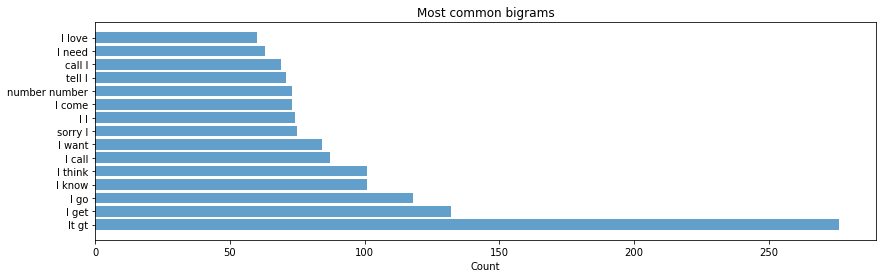

In [94]:
plot_grams(df_bigram2, gram_n=2)

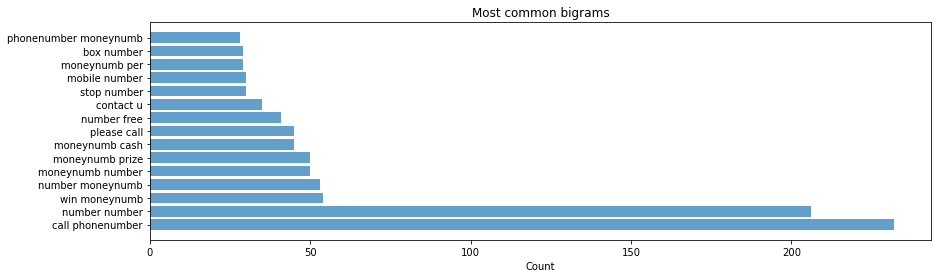

In [95]:
plot_grams(df_bigram1, gram_n=2)

In [96]:
#clear empty fields
df_gram=df_gram[df_gram['SMS'].map(len)>0]

#we separe the two type of data
df_gham=df_gram[df_gram['Nature']=='ham']
df_gspam=df_gram[df_gram['Nature']=='spam']


df_gham_downsampled = df_gham.sample(df_gspam.shape[0])
df_gham_downsampled.shape

# get the balanced dataset
df_model_gram= pd.concat([df_gspam , df_gham_downsampled])

In [97]:
# Getting bigrams 
df_model_gram.SMS=df_model_gram.SMS.apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(ngram_range =(2, 2))
X1 = vectorizer.fit_transform(df_model_gram.SMS) 
features = (vectorizer.get_feature_names())
print("\n\nX1 : \n", X1.toarray())



X1 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### TF-IDF

In [98]:

# Applying TFIDF
# You can still get n-grams here
vectorizer = TfidfVectorizer(ngram_range = (2, 2))
X2 = vectorizer.fit_transform(df_model_gram.SMS)
scores = (X2.toarray())
print("\n\nScores : \n", scores)
  
# Getting top ranking features
sums = X2.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0, col] ))
ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords : \n", words.head(20))



Scores : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Words : 
                        term       rank
5501          number number  28.904789
888        call phonenumber  27.968197
6424            please call  10.057085
9507          win moneynumb   9.640473
4269                  lt gt   9.484880
4785        moneynumb prize   9.427975
5471       number moneynumb   8.168783
4739         moneynumb cash   8.134952
4773       moneynumb number   7.309291
5374            number free   7.271707
1568       customer service   6.332147
4680          mobile number   5.848182
5681      number webaddress   5.718302
4778          moneynumb per   5.214902
8588            try contact   5.181749
3070         guarantee call   5.166679
6276  phonenumber moneynumb   5.164624
7851            stop number   5.151862
6605        prize guarantee   5.078336
713              box number   5.065308


In [99]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df_gram = pd.DataFrame(scores, columns=vectorizer.get_feature_names())
tfidf_df_gram.set_index(df_model_gram.index,inplace=True)

In [100]:
#Concatenate the score of tf-idf and the initial dataframe
df_model_gram=pd.concat([df_model_gram,tfidf_df_gram],axis=1)

<ipython-input-101-45a583014fb5>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Text(105.0, 0.5, 'Actual')

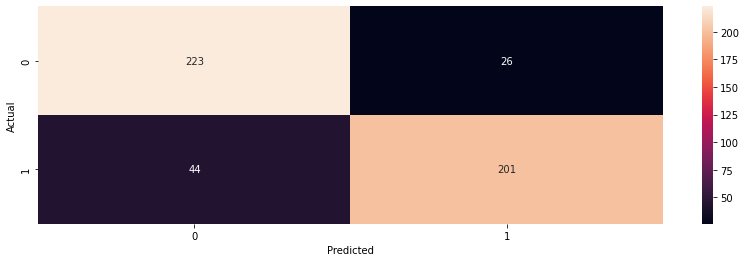

In [101]:
#Separate the training set in differents one
X_model=df_model_gram[df_model_gram.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model_gram[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Combination bi-gram and tf-idf

In [102]:
col=['Nature', 'SMS', 'count_upper', 'is_spam','number number', 'call phonenumber', 'please call', 'win moneynumb',
       'moneynumb prize', 'lt gt', 'number moneynumb', 'moneynumb cash',
       'moneynumb number', 'number free', 'customer service',
       'number webaddress', 'mobile number', 'moneynumb per', 'try contact',
       'guarantee call', 'phonenumber moneynumb', 'stop number',
       'prize guarantee', 'box number', 'moneynumb min', 'po box', 'land line',
       'webaddress webaddress', 'code number', 'nokia number',
       'await collection', 'go number', 'call number', 'prize number',
       'urgent mobile', 'valid numberhrs', 'number account', 'number ur',
       'phonenumber land', 'send stop', 'national rate', 'award moneynumb',
       'claim number', 'number claim', 'cash moneynumb', 'account statement',
       'private number', 'claim call', 'free call', 'receive moneynumb',
       'number get', 'number new', 'min number', 'tone number']

In [103]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model_gram.SMS)

#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorqizer.get_feature_names())
tfidf_df.set_index(df_model_gram.index,inplace=True)

#Concatenate the score of tf-idf and the initial dataframe
df_model=df_model_gram[col].merge( tfidf_df,left_index=True, right_index=True)

<ipython-input-104-9f9f79e96d14>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Text(105.0, 0.5, 'Actual')

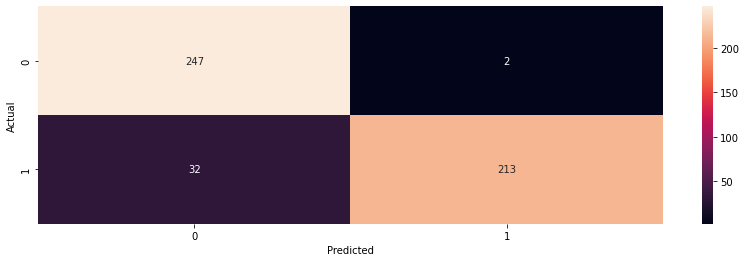

In [104]:
#Separate the training set in differents one
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### To develop:
* n-gram
* model to use
* TF-IDF

```

# Replace email address with 'emailaddress'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['message'] = df['message'].str.replace(r'£|\$', 'money-symbol'
Can help:

```


https://dimensionless.in/spam-detection-with-natural-language-processing-part-2/

https://www.analyticsvidhya.com/blog/2021/09/performing-email-spam-detection-using-bert-in-python/
